## Run Network
Script for using existing network to run on cohort data

In [1]:
import os
import xarray as xr
import numpy as np

In [2]:
# load data
data_dir = '/data/patricia/20200320_Test_Run/'
cohort_xr = xr.open_dataarray(os.path.join(data_dir,'deepcell_input.xr'))
print(cohort_xr.shape)

(1, 1024, 1024, 2)


In [3]:
import os
import numpy as np
from deepcell import model_zoo
import matplotlib.pyplot as plt
import math

In [6]:
# whole cell IF
experiment_folder = "20200227_IF_Training"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = '20200310_IF_Training_1_convolutional_61_rf_512_dense_128_conv.h5'
weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [4]:
# whole cell not denoised
experiment_folder = "20200227_IF_Training"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = 'Training_Freeze_1_Val_Noisy_256x256_stride_0.5_convolutional_61_rf_512_dense_128_conv.h5'
weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [4]:
# whole cell
experiment_folder = "20190822_training_freeze_1"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = 'training_freeze_1_H3_NaK_256x256_stride_0.3_test_convolutional_61_rf_512_dense_128_conv_epoch1.h5'
weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [4]:
# Nuclear
experiment_folder = "20191112_lab_combined"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = 'lab_combined_train_nolamin_256x256_stride_0.3_convolutional_61_rf_512_dense_128_conv.h5'
weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [ ]:
# DNA only
experiment_folder = "20191216_Mega_DNA"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = '20191216_Mega_DNA_convolutational_61_rf_512_dense_128_conv.h5'
weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [5]:
run_pixel_model = model_zoo.bn_feature_net_skip_2D(
    n_skips=3,
    fgbg_model=None,
    n_dense_filters=512,
    n_conv_filters=128,
    n_features=3,
    norm_method='std',
    receptive_field=61,
    last_only=False,
    n_channels=1,    
    input_shape=(256, 256, 2))

run_pixel_model.load_weights(weights_path)

W0321 01:23:43.743762 140176412411712 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
from deepcell_toolbox.utils import tile_image
tiled_data, tiled_info = tile_image(cohort_xr.values, (256, 256))

In [7]:
model_output = run_pixel_model.predict(tiled_data)[-1]

In [8]:
def untile_image(tiles, tiles_info, dtype,
                 model_input_shape=(512, 512)):
    """Untile a set of tiled images back to the original model shape.
    Args:
        tiles (numpy.array): The tiled images image to untile.
        tiles_info (dict): Details of how the image was tiled (from tile_image).
        model_input_shape (tuple): The input size of the model.
    Returns:
        numpy.array: The untiled image.
    """
    _axis = 1
    image_shape = tiles_info['image_shape']
    batches = tiles_info['batches']
    x_starts = tiles_info['x_starts']
    x_ends = tiles_info['x_ends']
    y_starts = tiles_info['y_starts']
    y_ends = tiles_info['y_ends']
    stride_x = tiles_info['stride_x']
    stride_y = tiles_info['stride_y']

    tile_size_x = model_input_shape[0]
    tile_size_y = model_input_shape[1]

    image_shape = tuple(list(image_shape[0:3]) + [tiles.shape[-1]])
    image = np.zeros(image_shape, dtype=dtype)

    zipped = zip(tiles, batches, x_starts, x_ends, y_starts, y_ends)
    for tile, batch, x_start, x_end, y_start, y_end in zipped:
        tile_x_start = 0
        tile_x_end = tile_size_x
        tile_y_start = 0
        tile_y_end = tile_size_y

        if x_start != 0:
            x_start += (tile_size_x - stride_x) / 2
            tile_x_start += (tile_size_x - stride_x) / 2
        if x_end != image_shape[_axis]:
            x_end -= (tile_size_x - stride_x) / 2
            tile_x_end -= (tile_size_x - stride_x) / 2
        if y_start != 0:
            y_start += (tile_size_y - stride_y) / 2
            tile_y_start += (tile_size_y - stride_y) / 2
        if y_end != image_shape[_axis]:
            y_end -= (tile_size_y - stride_y) / 2
            tile_y_end -= (tile_size_y - stride_y) / 2

        x_start = np.int(x_start)
        x_end = np.int(x_end)
        y_start = np.int(y_start)
        y_end = np.int(y_end)

        tile_x_start = np.int(tile_x_start)
        tile_x_end = np.int(tile_x_end)
        tile_y_start = np.int(tile_y_start)
        tile_y_end = np.int(tile_y_end)

        image[batch, x_start:x_end, y_start:y_end, :] = \
            tile[tile_x_start:tile_x_end, tile_y_start:tile_y_end, :]

    return image

In [9]:
model_output_untile = untile_image(model_output, tiled_info, "float32", (256, 256))

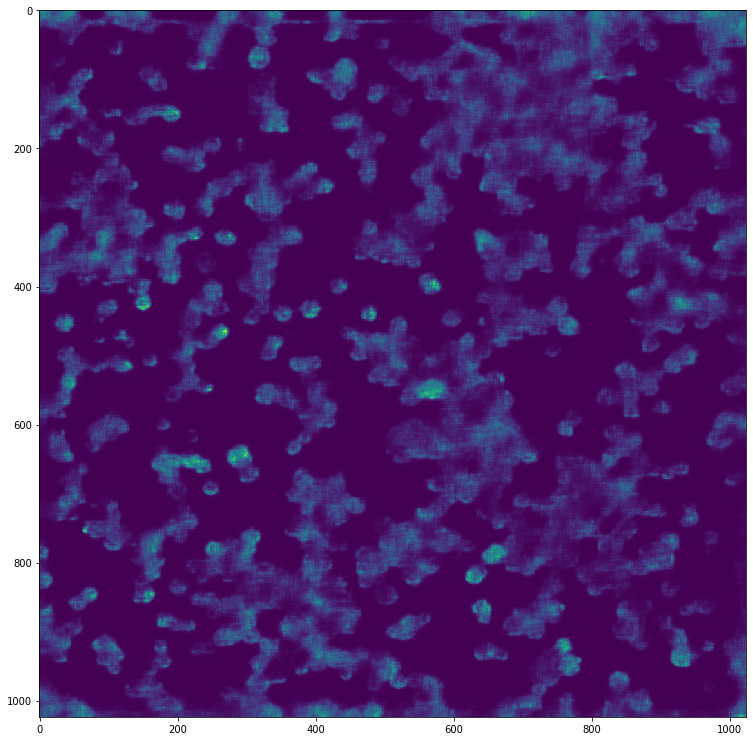

In [12]:
plt.figure(figsize = (13, 13))
plt.imshow(model_output_untile[0, :, :, 1])

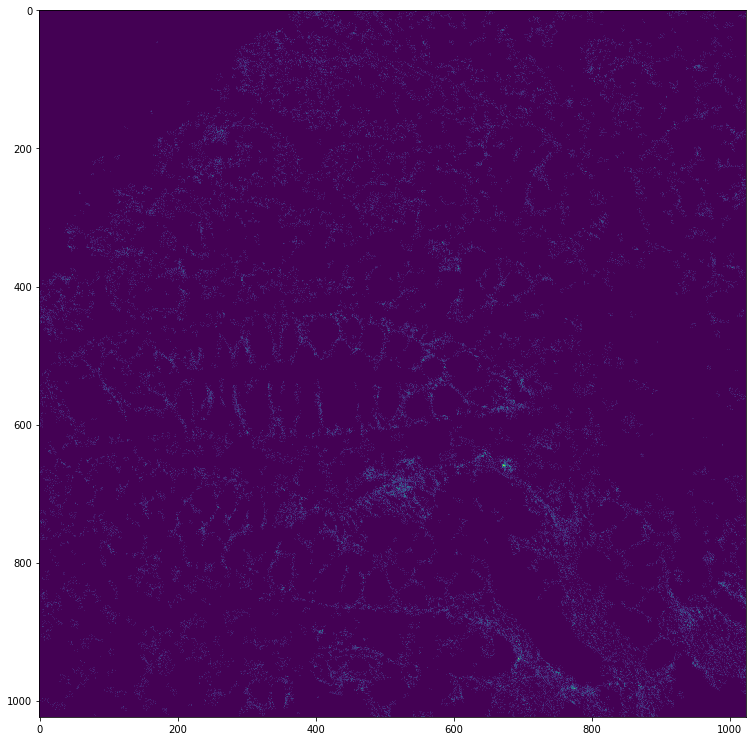

In [18]:
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr[60, :, :, 1])

In [13]:
xr_output = xr.DataArray(model_output_untile[:, :, :, 1:2],
                         coords=[cohort_xr.fovs, range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), ['pixelwise_interior']],
                         dims=['fovs', 'rows', 'cols', 'models'])
xr_output.to_netcdf(os.path.join(data_dir, "deepcell_output_pixelwise.xr"), format="NETCDF4")

# Run watershed network

In [25]:
# nuclear
experiment_folder = "20191112_lab_combined"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = 'lab_combined_train_nolamin_256x256_stride_0.3_convolutional_watershed_61_rf_256_dense_64_conv_epoch2.h5'
watershed_weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [27]:
run_watershed_model = model_zoo.bn_feature_net_skip_2D(
     n_skips=3,
    fgbg_model=None,
    n_dense_filters=256,
    n_conv_filters=64,
    n_features=4,
    norm_method='std',
    receptive_field=61,
    last_only=False,
    n_channels=1,    
    input_shape=(256, 256, 2))

run_watershed_model.load_weights(watershed_weights_path)

In [28]:
watershed_model_output = run_watershed_model.predict(tiled_data)[-1]

In [29]:
watershed_model_output_untile = untile_image(watershed_model_output, tiled_info, "float32", (256, 256))

In [32]:
argmax_images = []
for j in range(watershed_model_output_untile.shape[0]):
    argmax_images.append(np.argmax(watershed_model_output_untile[j, ...], axis=-1))
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

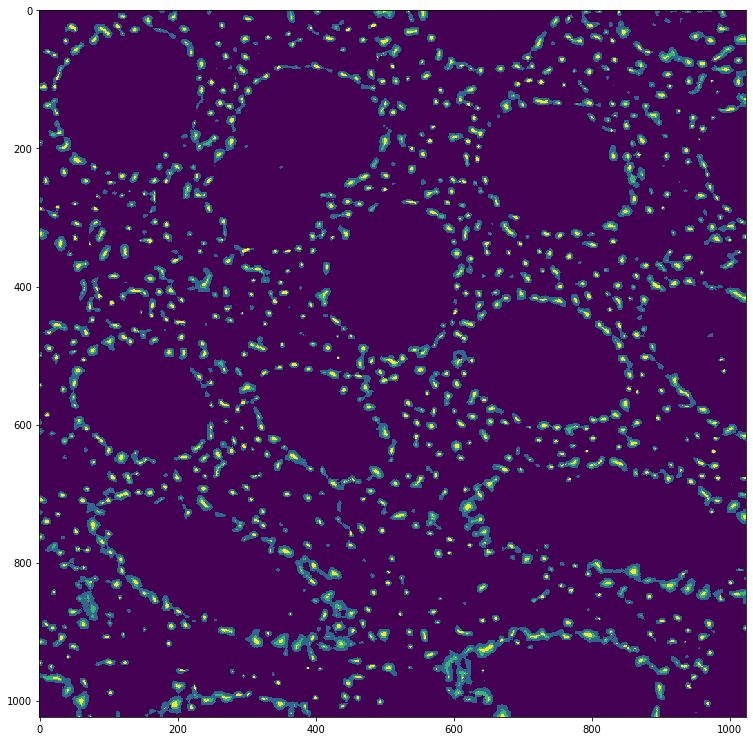

In [34]:
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[10, :, :, 0])

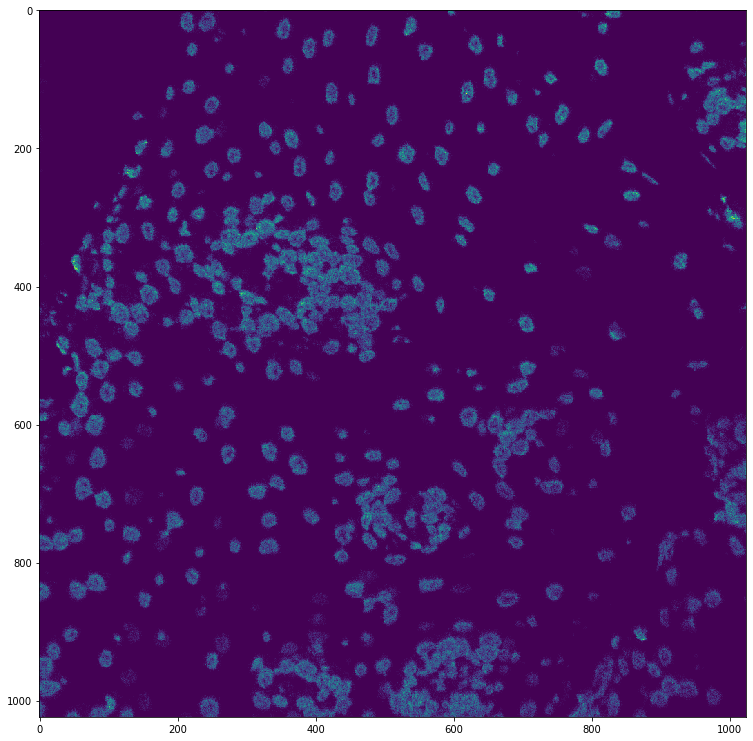

In [26]:
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr.values[0, :, :, 0])

In [28]:
xr_output_watershed = xr.DataArray(argmax_images,
                         coords=[cohort_xr.coords['points'], range(cohort_xr.shape[1]), range(cohort_xr.shape[2]), ['watershed_argmax']],
                         dims=['points', 'rows', 'cols', 'models'])
xr_output_watershed.to_netcdf(os.path.join(data_dir, "deepcell_output_138_watershed.nc"), format="NETCDF3_64BIT")